In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
df = pd.read_csv('/content/Dữ liệu Lịch sử VN 30.csv')
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,29/09/2023,"1,166.26","1,169.26","1,176.77","1,165.15",144.90K,0.16%
1,28/09/2023,"1,164.45","1,167.96","1,168.09","1,144.47",193.65K,-0.36%
2,27/09/2023,"1,168.60","1,154.54","1,168.60","1,141.09",190.47K,1.32%
3,26/09/2023,"1,153.37","1,161.62","1,174.24","1,152.44",242.76K,-0.57%
4,25/09/2023,"1,159.94","1,195.36","1,199.65","1,159.94",263.86K,-3.15%
...,...,...,...,...,...,...,...
3673,09/01/2009,312.90,312.90,312.90,312.90,NaN,-0.39%
3674,08/01/2009,314.14,314.14,314.14,314.14,NaN,-1.99%
3675,07/01/2009,320.53,320.53,320.53,320.53,NaN,2.01%
3676,06/01/2009,314.21,314.21,314.21,314.21,NaN,0.96%


In [ ]:
  df.rename(columns={'Ngày': 'Time'}, inplace=True)
  df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y')
  df.index = df['Time']
  df.drop(["Time"], axis='columns', inplace=True)
  df.sort_index(ascending=True, inplace=True)
  df.drop(columns=['KL', '% Thay đổi'], inplace=True)
  df.rename(columns={'Lần cuối': 'Close', 'Mở': 'Open', 'Cao': 'High', 'Thấp': 'Low'}, inplace=True)
  df['Close'] = pd.to_numeric(df['Close'].str.replace(',', ''), errors='coerce')
  df['Open'] = pd.to_numeric(df['Open'].str.replace(',', ''), errors='coerce')
  df['High'] = pd.to_numeric(df['High'].str.replace(',', ''), errors='coerce')
  df['Low'] = pd.to_numeric(df['Low'].str.replace(',', ''), errors='coerce')

In [ ]:
df

,Close,Open,High,Low
Time,,,,
2009-01-05,311.23,311.23,311.23,311.23
2009-01-06,314.21,314.21,314.21,314.21
2009-01-07,320.53,320.53,320.53,320.53
2009-01-08,314.14,314.14,314.14,314.14
2009-01-09,312.90,312.90,312.90,312.90
...,...,...,...,...
2023-09-25,1159.94,1195.36,1199.65,1159.94
2023-09-26,1153.37,1161.62,1174.24,1152.44
2023-09-27,1168.60,1154.54,1168.60,1141.09


In [ ]:
print(df.dtypes)

Close    float64
Open     float64
High     float64
Low      float64
dtype: object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3678 entries, 2009-01-05 to 2023-09-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3678 non-null   float64
 1   Open    3678 non-null   float64
 2   High    3678 non-null   float64
 3   Low     3678 non-null   float64
dtypes: float64(4)
memory usage: 143.7 KB


In [ ]:
df['Close'] = df['Close'].fillna(method='ffill', inplace=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3678 entries, 2009-01-05 to 2023-09-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3678 non-null   float64
 1   Open    3678 non-null   float64
 2   High    3678 non-null   float64
 3   Low     3678 non-null   float64
dtypes: float64(4)
memory usage: 143.7 KB


In [ ]:
df_month = df.resample('M').mean()

In [ ]:
df_month.shape[0]-df_month.shape[0]*0.2

141.6

In [ ]:
df_month.index[142]

Timestamp('2020-11-30 00:00:00', freq='M')

In [ ]:
df_month['2020-06-30':'2021-06-30'].Close

Time
2020-06-30     808.176364
2020-07-31     788.903043
2020-08-31     793.340476
2020-09-30     841.222381
2020-10-31     890.926364
2020-11-30     932.560476
2020-12-31    1022.415217
2021-01-31    1128.167500
2021-02-28    1141.328000
2021-03-31    1184.748696
2021-04-30    1274.834000
2021-05-31    1396.133500
2021-06-30    1486.825000
Freq: M, Name: Close, dtype: float64

In [ ]:
target_col = 'Close'

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(df_month, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, lw=2, title='', figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('VN30', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.show()

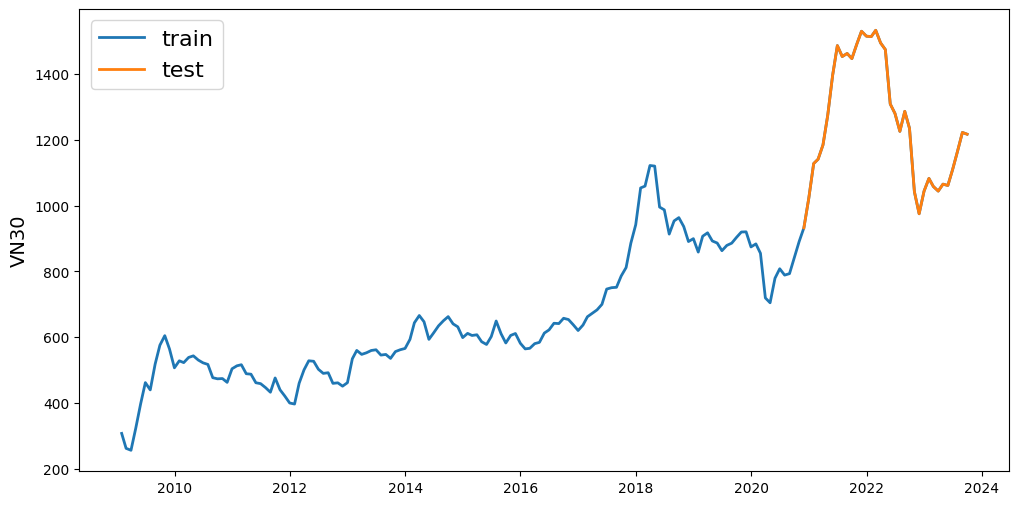

In [ ]:
line_plot(df_month.Close, test.Close, 'train', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
np.random.seed(42)
window_len = 1
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 25
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
learning_rate=1e-6

In [ ]:
def extract_window_data(df, window_len= window_len, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len= window_len, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons, activ_func, dropout, loss, optimizer):
    model = Sequential()

    # First LSTM layer - define input_shape and set return_sequences=True
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))

    # Subsequent LSTM layers - only set return_sequences=True for all but the last LSTM layer
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout))

    # Last LSTM layer - do not set return_sequences as it should be False by default
    model.add(LSTM(neurons))
    model.add(Dropout(dropout))

    # Output layer
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer)

    return model

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df_month, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
print(train.shape[0])
print(test.shape[0])

142
35


In [ ]:
print(len(X_train))
print(len(X_test))

141
34


In [ ]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, activ_func='linear', dropout=dropout, loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
6/6 [==============================] - 10s 341ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 2/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 3/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 9/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 10/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 11/50
6/6 [==========

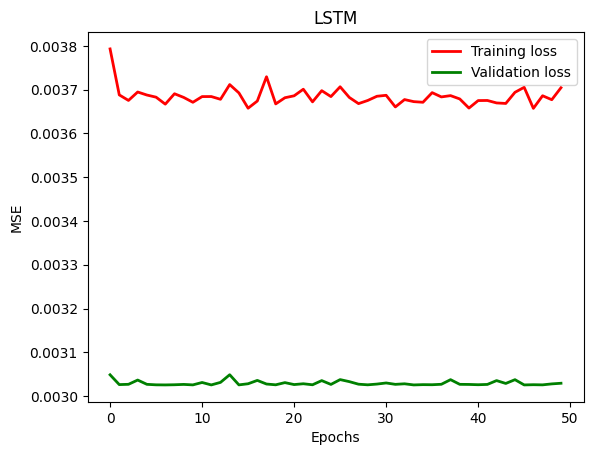

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

2/2 [==============================] - 2s 9ms/step


In [ ]:
def line_plot1(line1, line2, line3, label1=None, label2=None, label3=None, title='VN30 Prediction', lw=1, figsize=(12,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('VN30', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.show()

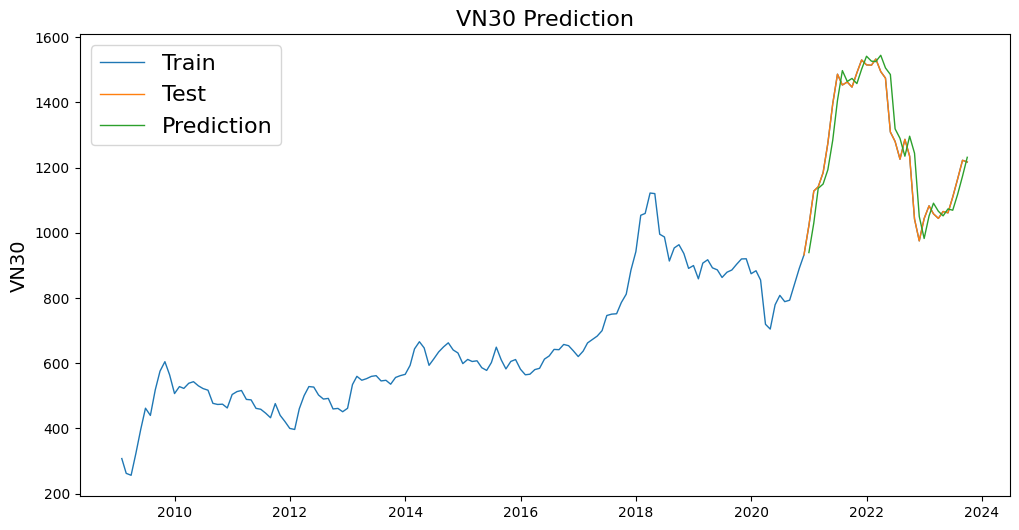

In [ ]:
preds = test[target_col].values[:-window_len] * (preds+1)
preds = pd.Series(index=targets.index, data=preds)
line_plot1(df_month["Close"], test['Close'], preds, 'Train', 'Test', 'Prediction')

In [ ]:
targets

Time
2020-12-31    1022.415217
2021-01-31    1128.167500
2021-02-28    1141.328000
2021-03-31    1184.748696
2021-04-30    1274.834000
2021-05-31    1396.133500
2021-06-30    1486.825000
2021-07-31    1453.654091
2021-08-31    1462.926364
2021-09-30    1447.267000
2021-10-31    1491.171429
2021-11-30    1530.529091
2021-12-31    1515.496957
2022-01-31    1514.280526
2022-02-28    1533.450625
2022-03-31    1494.911739
2022-04-30    1474.824500
2022-05-31    1309.351000
2022-06-30    1280.439091
2022-07-31    1226.057143
2022-08-31    1286.940000
2022-09-30    1235.261000
2022-10-31    1042.407143
2022-11-30     975.403636
2022-12-31    1043.924545
2023-01-31    1082.902500
2023-02-28    1058.397500
2023-03-31    1044.384348
2023-04-30    1065.473000
2023-05-31    1061.515500
2023-06-30    1109.795909
2023-07-31    1165.240000
2023-08-31    1222.701304
2023-09-30    1217.350526
Freq: M, Name: Close, dtype: float64

In [ ]:
preds

Time
2020-12-31     939.520377
2021-01-31    1030.045724
2021-02-28    1136.587259
2021-03-31    1149.845978
2021-04-30    1193.590732
2021-05-31    1284.348363
2021-06-30    1406.553147
2021-07-31    1497.921497
2021-08-31    1464.503027
2021-09-30    1473.844500
2021-10-31    1458.068267
2021-11-30    1502.300364
2021-12-31    1541.951761
2022-01-31    1526.807439
2022-02-28    1525.581930
2022-03-31    1544.895099
2022-04-30    1506.068590
2022-05-31    1485.831435
2022-06-30    1319.122970
2022-07-31    1289.995285
2022-08-31    1235.207473
2022-09-30    1296.544712
2022-10-31    1244.480021
2022-11-30    1050.186853
2022-12-31     982.683285
2023-01-31    1051.715581
2023-02-28    1090.984436
2023-03-31    1066.296550
2023-04-30    1052.178815
2023-05-31    1073.424856
2023-06-30    1069.437820
2023-07-31    1118.078557
2023-08-31    1173.936439
2023-09-30    1231.826589
Freq: M, dtype: float64

In [ ]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(preds, targets)
MAE

51.40169894027579

In [ ]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(preds, targets)
MSE

4554.309031821434

In [ ]:
from sklearn.metrics import r2_score
R2 = r2_score(preds, targets)
R2

0.8755458682816386

In [ ]:
mape = np.sum(np.abs((targets - preds) / targets))*(100 / len(targets))
rmse = np.sqrt(mean_squared_error(targets, preds))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse}")

MAPE: 4.25%
RMSE: 67.4856209263976
